# Big Data Application: Modeling for Crop Yield Estimation

This jupyter notebook is addressed for creating model that can estimate crop yield in North Dakota, United States. The detail workflow of this project can be seen in [here](https://drive.google.com/file/d/1u3jHTnLqoxMca7SRzgnvGjP-iBvfTnls/view?usp=sharing).

## 0. Install & Load Packages

In [1]:
#install packages
!pip install tensorflow

In [2]:
#load packages

#packages for manipulating dataframe
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import sklearn

#packages for machine learning
##train-test-split
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve

##method 1: Linear Regression (LR)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

##method 2: Random Forest Regressor (RF)
import rfpimp
from sklearn.ensemble import RandomForestRegressor

##method 3: Gradient Boosting Regressor (XGB)

##method 4: Artificial Neural Network (ANN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##cross validation

##evaluation metrics (R2 and RMSE)
from sklearn.metrics import r2_score, mean_squared_error

#data visualization
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

2024-03-26 13:00:11.942591: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 13:00:11.946468: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 13:00:11.996864: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 13:00:13.166081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Load & Cleaning Data

In [3]:
#load data
soybean_2018 = pd.read_csv('https://www.dropbox.com/scl/fi/7oje7pt1drpmurfqfaa2t/standardized_2018_County_Summary_Merged.csv?rlkey=i1ka8sg8g4vdykazjpkfjnp2a&dl=1')
soybean_2019 = pd.read_csv('https://www.dropbox.com/scl/fi/72z6twn70nd22tnrmzn1y/standardized_2019_County_Summary_Merged.csv?rlkey=48zahb5ad25gfomzkyf3ghnjp&dl=1')
soybean_2020 = pd.read_csv('https://www.dropbox.com/scl/fi/37hczf92ev9n6vkd5tzuc/standardized_2020_County_Summary_Merged.csv?rlkey=pviu2572il5prpt69j13o3rux&dl=1')
soybean_2021 = pd.read_csv('https://www.dropbox.com/scl/fi/87vyoohpo80wyd9nyk0y9/standardized_2021_County_Summary_Merged.csv?rlkey=sh0gydlfw56tfjbp9zh3kqjyd&dl=1')
soybean_2022 = pd.read_csv('https://www.dropbox.com/scl/fi/jvv0iugqk9x045awb7ivk/standardized_2022_County_Summary_Merged.csv?rlkey=yx8yzpy8idff7761jpsmvgkjn&dl=1')
soybean_2023 = pd.read_csv('https://www.dropbox.com/scl/fi/09ger7p2qetczj4p6u0nk/standardized_2023_County_Summary_Merged.csv?rlkey=va8suq9c9wt0psoy0f1iden9m&dl=1')

In [4]:
soybean_list = [soybean_2018, soybean_2019, soybean_2020, soybean_2021, soybean_2022, soybean_2023]
soybean_df = pd.concat(soybean_list)
soybean_df = soybean_df.drop(['NAME','GEOID'], axis=1)
soybean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 0 to 52
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LST     316 non-null    float64
 1   SMS     316 non-null    float64
 2   SAR     316 non-null    float64
 3   PA      316 non-null    float64
 4   NDVI    316 non-null    float64
 5   YIELD   316 non-null    float64
dtypes: float64(6)
memory usage: 17.3 KB


<Axes: >

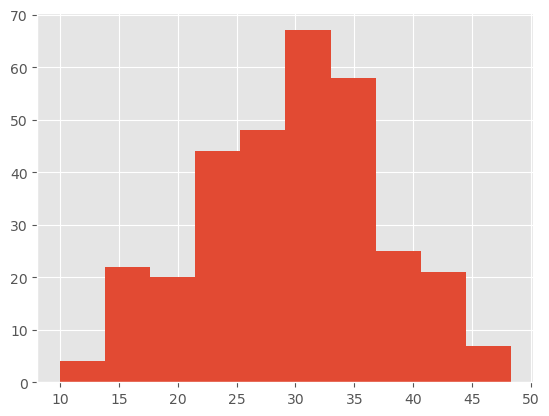

In [5]:
soybean_df.YIELD.hist()

Text(0.5, 1.0, 'Correlation Matrix')

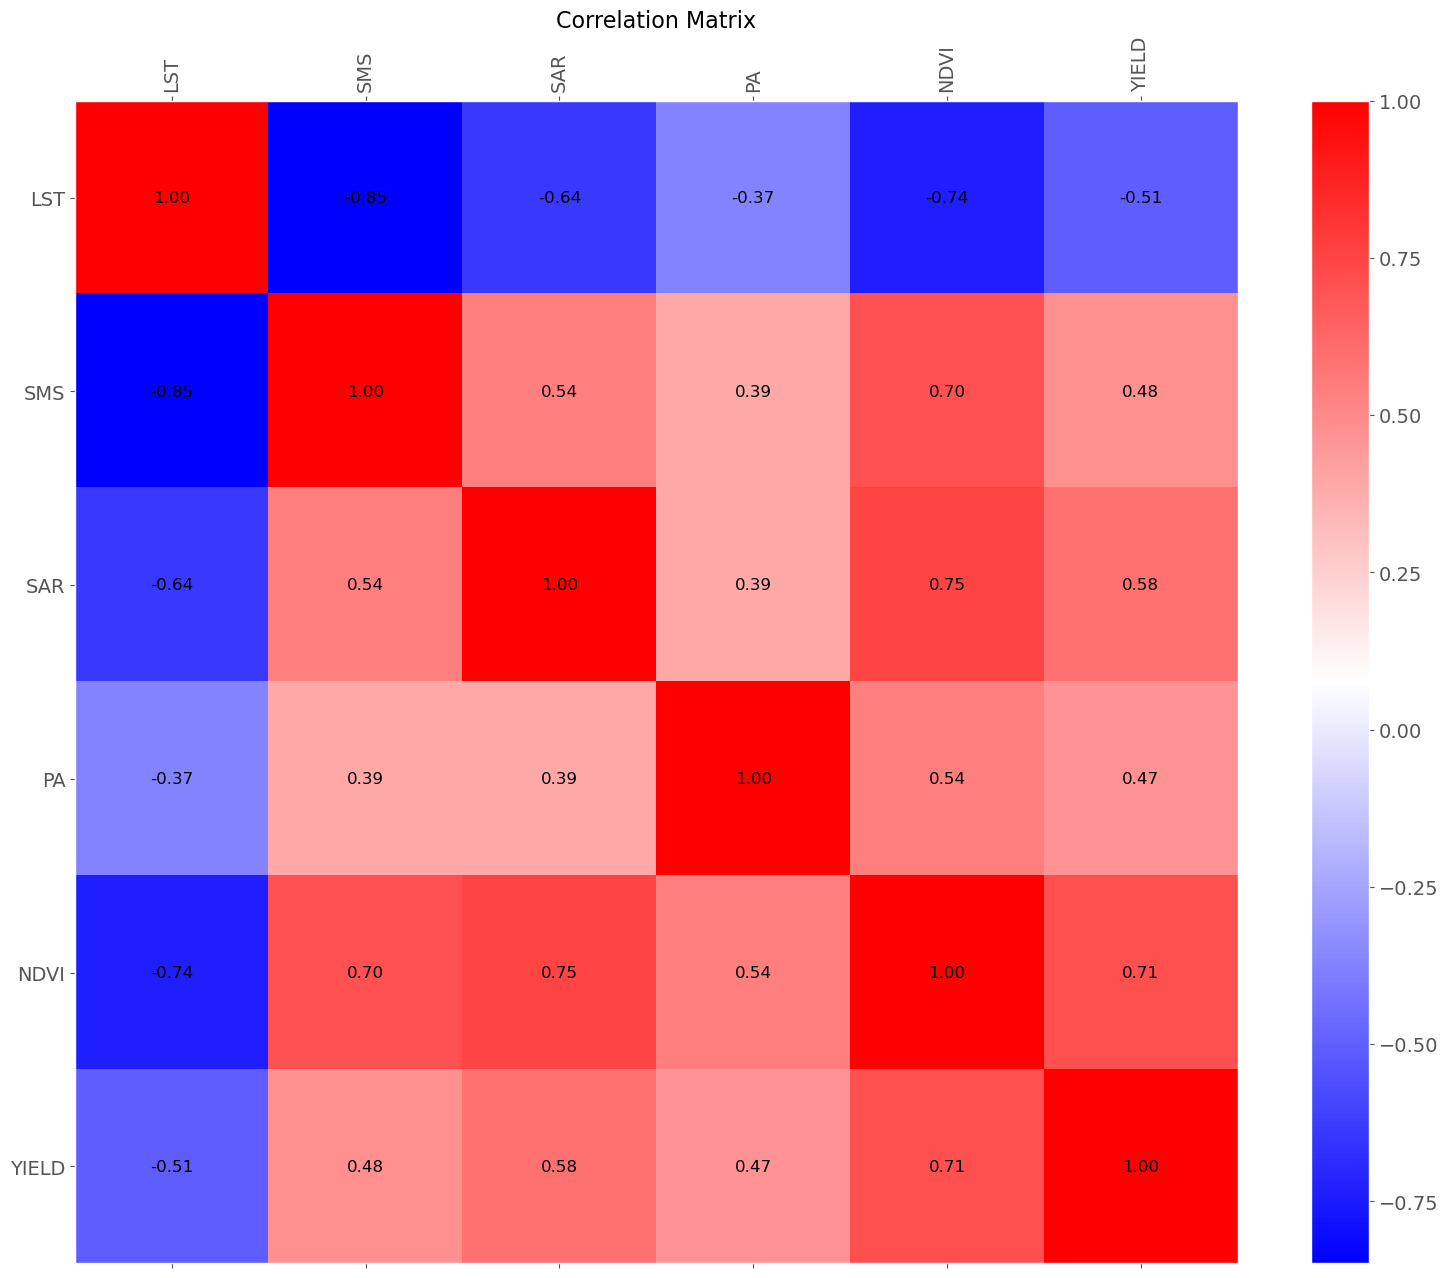

In [6]:
# Correlation coefficients
correlation_matrix = soybean_df.corr()

plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(soybean_df.corr(), fignum=f.number,cmap='bwr')
plt.xticks(range(soybean_df.shape[1]), soybean_df.columns, fontsize=14, rotation=90)
plt.yticks(range(soybean_df.shape[1]), soybean_df.columns, fontsize=14)

for i in range(soybean_df.shape[1]):
    for j in range(soybean_df.shape[1]):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', fontsize=12, color='black')

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.savefig('correlation_matrix_soybean.png', bbox_inches='tight')

plt.title('Correlation Matrix', fontsize=16)

## 2. Train & Test Data Split

In [17]:
#split the dataset
X = soybean_df.drop('YIELD', axis=1)
y = soybean_df['YIELD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

## 3. Model Training and Parameter Tuning

### 3.1. Linear Regression (LR)

In [18]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

LinearRegression()

### 3.2. Random Forest Regressor (RF)

In [19]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[3,5,10,20,30], 'min_samples_split':[2,4,6,8,10]}


randomState_dt = 10000
model_rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(model_rf, hyperparameters)

clf.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 3, 'min_samples_split': 2}
The best score is: 
0.5096073244215513


In [20]:
# Train the final RF
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, random_state=10000)

### 3.3. Gradient Boosting Regressor (XGB)

In [ ]:
model_xgb =

### 3.4. Artificial Neural Network (ANN)

In [21]:
model_ann = keras.Sequential([
    layers.Input(shape=(5,)),  # Input layer
    layers.Dense(128, activation='relu'),  # Hidden layer with ReLU activation
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(64, activation='relu'),  # Additional hidden layer
    layers.Dropout(0.3),  # Another dropout layer
    layers.Dense(1)  # Output layer
])

#measuring the training with certain metrics
model_ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [22]:
#train the model
model_ann.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 926.3522 - val_accuracy: 0.0000e+00 - val_loss: 899.7130
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 898.8789 - val_accuracy: 0.0000e+00 - val_loss: 864.6285
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 855.1393 - val_accuracy: 0.0000e+00 - val_loss: 820.9792
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 792.0721 - val_accuracy: 0.0000e+00 - val_loss: 763.4991
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 696.6741 - val_accuracy: 0.0000e+00 - val_loss: 689.5862
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 654.2740 - val_accuracy: 0.0000e+00 - val_loss: 598.8350
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 578.5795 - val_accuracy: 0.0000e+00 - val_loss: 494.6883
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

## 4. Model Evaluation and Performance Comparison

Comparing the performance with using R2 and Root Mean Squared Error (RMSE).

### 4.1. E. Linear Regression (LR)

In [23]:
train_predictions = model_lr.predict(X_train)
test_predictions = model_lr.predict(X_test)

r2_train_lr = r2_score(y_train, train_predictions)
r2_test_lr = r2_score(y_test, test_predictions)

rmse_train_lr = mean_squared_error(y_train, train_predictions, squared=False)
rmse_test_lr = mean_squared_error(y_test, test_predictions, squared=False)

print(f"Training R^2: {r2_train_lr:.4f}")
print(f"Test R^2: {r2_test_lr:.4f}")
print(f"Training RMSE: {rmse_train_lr:.4f}")
print(f"Test RMSE: {rmse_test_lr:.4f}")

Training R^2: 0.5434
Test R^2: 0.4428
Training RMSE: 5.1400
Test RMSE: 5.9105


### 4.2. E. Random Forest Regressor (RF)

In [24]:
r2_train_rf = rf_final.score(X=X_train, y=y_train)
r2_test_rf = rf_final.score(X=X_test, y=y_test)

print("R2 on the training data:")
print(r2_train_rf)
print("R2 on the testing data:")
print(r2_test_rf)

R2 on the training data:
0.6832842781707053
R2 on the testing data:
0.49405126065030003


In [25]:
rmse_train_rf = mean_squared_error(y_train, rf_final.predict(X_train), squared=False)
rmse_test_rf = mean_squared_error(y_test, rf_final.predict(X_test), squared=False)

print("RMSE on the training data:")
print(rmse_train_rf)
print("RMSE on the testing data:")
print(rmse_test_rf)

RMSE on the training data:
4.280907710841681
RMSE on the testing data:
5.632071090003778


                                      Importance
Feature                                         
NDVI                                      0.6358
SAR                                       0.0521
SMS                                       0.0074
LST                                       0.0043
PA                                       -0.0123


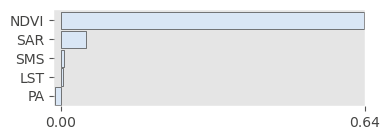

In [28]:
# Calculate and plot the feature importance of the RF model
imp = rfpimp.importances(rf_final, X_test, y_test)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 4.3. E. Gradient Boosting Regressor (XGB)

### 4.4. E. Artificial Neural Network (ANN)

In [29]:
#predictions
y_pred_train_ann = model_ann.predict(X_train).flatten()
y_pred_test_ann = model_ann.predict(X_test).flatten()

#Compute R2 and RMSE
r2_train_ann = np.round(r2_score(y_train, y_pred_train_ann),2)
r2_test_ann = np.round(r2_score(y_test, y_pred_test_ann),2)
rmse_train_ann = np.round(np.sqrt(mean_squared_error(y_train, y_pred_train_ann)),2)
rmse_test_ann = np.round(np.sqrt(mean_squared_error(y_test, y_pred_test_ann)),2)

#print the result
print("Train R2:", r2_train_ann)
print("Test R2:", r2_test_ann)
print("Train RMSE:", rmse_train_ann)
print("Test RMSE:", rmse_test_ann)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train R2: 0.6
Test R2: 0.44
Train RMSE: 4.83
Test RMSE: 5.9


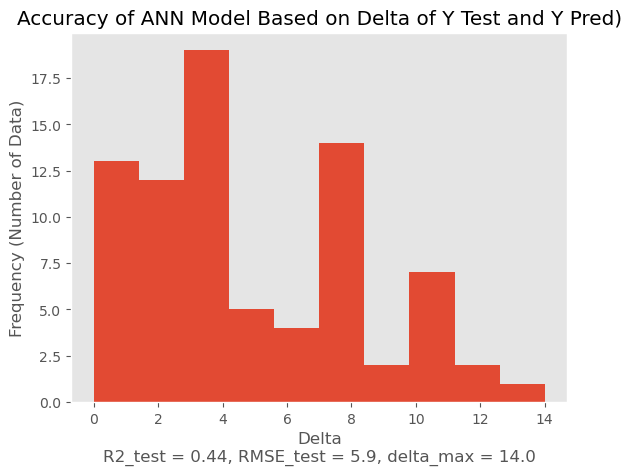

In [30]:
#crosscheck the y value between real and predicted
crosscheck_y_dict = {
    'y_test' : y_test,
    'y_pred' : np.round(y_pred_test_ann,0),
    'delta' : np.abs(np.round((y_test - y_pred_test_ann),0))
}

#plotting histogram
crosscheck_y_df = pd.DataFrame(crosscheck_y_dict)
plt.hist(crosscheck_y_df['delta'], bins=10)
plt.xlabel(f'Delta\nR2_test = {r2_test_ann}, RMSE_test = {rmse_test_ann}, delta_max = {crosscheck_y_df.delta.max()}')
plt.ylabel('Frequency (Number of Data)')
plt.title(f"Accuracy of ANN Model Based on Delta of Y Test and Y Pred)")
plt.show()

### 4.5. Model Performance Comparison

In [31]:
#please input your metrics in here
metrics_dict = {
    'metrics': ["Train R2","Test R2","Train RMSE","Test RMSE"],
    'LR': [r2_train_lr, r2_test_lr, rmse_train_lr, rmse_test_lr],
    'RF': [r2_train_rf, r2_test_rf, rmse_train_rf, rmse_test_rf],
    'XGB': ["Train R2","Test R2","Train RMSE","Test RMSE"],
    'ANN': [r2_train_ann, r2_test_ann, rmse_train_ann, rmse_test_ann]
}

#create dataframe
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.set_index('metrics')

,LR,RF,XGB,ANN
metrics,,,,
Train R2,0.5434,0.6833,Train R2,0.6000
Test R2,0.4428,0.4941,Test R2,0.4400
Train RMSE,5.1400,4.2809,Train RMSE,4.8300
Test RMSE,5.9105,5.6321,Test RMSE,5.9000


Based on the comparison, it can be said that the best model that can be used for estimating crop yield is []. From this point, [] model would be used for estimation phase (step 5).

## 5. Crop Yield Estimation and Export Result